# West Coast Vacation

Planning vacations can be tricky. It's not a secret that different people look for different things when it comes to vacations. Culture, entertainment, food, sports, and natural sights can all be important for tourists. In this assignment, I will try to build a system that recommends the best neighborhood to stay at during your vacation based on you preferences for what a good vacation should include.

For the purposes of the assignment I will use three cities in California, namely San Fracisco, Los Angeles, and San Diego. I will get the information on all neighborhoods in each city and then cluster them all together. I will then explore the clusters to find the similarities and hopefully there will be enough similarities to recommend specific neighborhood clusters for different types of vacations

### Part 1: Initializing Coordinates

I will first import some libraries that I'll use for this assignment

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Then I'll create a geolocator object for each city

In [2]:
address_sf = 'San Francisco, CA, US'

geolocator_sf = Nominatim(user_agent="sf_explorer")
location_sf = geolocator_sf.geocode(address_sf)
latitude_sf = location_sf.latitude
longitude_sf = location_sf.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude_sf, longitude_sf))

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


In [3]:
address_la = 'Los Angeles, CA'

geolocator_la = Nominatim(user_agent="la_explorer")
location_la = geolocator_la.geocode(address_la)
latitude_la = location_la.latitude
longitude_la = location_la.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude_la, longitude_la))

The geograpical coordinate of Los Angeles are 34.0536834, -118.2427669.


In [4]:
address_sd = 'San Diego, CA'

geolocator_sd = Nominatim(user_agent="sd_explorer")
location_sd = geolocator_sd.geocode(address_sd)
latitude_sd = location_sd.latitude
longitude_sd = location_sd.longitude
print('The geograpical coordinate of San Diego are {}, {}.'.format(latitude_sd, longitude_sd))

The geograpical coordinate of San Diego are 32.7174209, -117.1627714.


### Part 2: Scraping the Neighborhoods

I will now scrape wikipedia for the names of neighborhoods in each city

In [5]:
from bs4 import BeautifulSoup
import requests

In [6]:
source_sf = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_San_Francisco').text
source_la = requests.get('https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_of_Los_Angeles').text
source_sd = requests.get('https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego').text

These wikipedia pages are quite different from each other. So, I'll use different approaches in scraping them.

#### I'll start with San Francisco

In [7]:
soup_sf = BeautifulSoup(source_sf, 'lxml')

The most reliable way to get neighbourhood names in San Francisco is to use h2 header

In [8]:
sf_hood_list = soup_sf.find_all('h2')

In [9]:
tag_list =[]
for tag in sf_hood_list:
    tag_list.append(tag.text)

By looking at this tag list, we can see that we need to get rid of '[edit]' string at the end of each of them and we also need to get rid of first item on the list(word 'contents') and last four items on the list (references, links, etc.) that are not the names of neighbourhood

In [10]:
tag_list = tag_list[1:-4]

In [11]:
sf_list = []
for item in tag_list:
    sf_list.append(item[0:-6])

Now that we have a clean list of all San Francisco Neighbourhoods, we can find their coordinates and create a list of lists with neighborhood names, latitudes, and longitudes. We'll first convert a list to pandas dataframe and then create new columns for longitude and latitude

In [12]:
sf_coordinates = pd.DataFrame(sf_list, columns =['Neighbourhood'])

In [13]:
sf_coordinates['Latitude']=0
sf_coordinates['Longitude']=0

In [14]:
for item in sf_coordinates['Neighbourhood']:
    address = '{}, San Francisco, CA, US'.format(item)
    geolocator_sf = Nominatim(user_agent="sf_explorer")
    location_sf = geolocator_sf.geocode(address)
    if location_sf is not None:
        sf_coordinates['Latitude'].loc[sf_coordinates['Neighbourhood']==item] = location_sf.latitude
        sf_coordinates['Longitude'].loc[sf_coordinates['Neighbourhood']==item] = location_sf.longitude

/Users/Anna/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
sf_coordinates.head()

,Neighbourhood,Latitude,Longitude
0,Alamo Square,37.776357,-122.434694
1,Anza Vista,37.780836,-122.443149
2,Ashbury Heights,0.000000,0.000000
3,Balboa Park,37.724949,-122.444805
4,Balboa Terrace,0.000000,0.000000


In [16]:
sf_coordinates.tail()

,Neighbourhood,Latitude,Longitude
114,West Portal,37.741141,-122.465634
115,Western Addition,37.779559,-122.429810
116,Westwood Highlands,0.000000,0.000000
117,Westwood Park,0.000000,0.000000
118,Yerba Buena,-5.735634,-79.043992


We can see now that some neighborhoods have 0s for the longitude and latitude values. We can also see that the last neighborhood is not located in San Francisco (probably due to name being the same as a town in Peru). I'll drop these entries for the simplicity of the task

In [17]:
sf_coordinates = sf_coordinates[sf_coordinates['Latitude']!=0].iloc[:-1, :]
sf_coordinates

,Neighbourhood,Latitude,Longitude
0,Alamo Square,37.776357,-122.434694
1,Anza Vista,37.780836,-122.443149
3,Balboa Park,37.724949,-122.444805
5,Bayview,37.728889,-122.392500
6,Belden Place,37.791744,-122.403886
7,Bernal Heights,37.741001,-122.414214
8,Buena Vista,37.806532,-122.420648
10,Castro,37.760856,-122.434957
13,China Basin,37.776330,-122.391839
14,Chinatown,37.794301,-122.406376


And now we got it! Let's move on to Los Angeles

#### Los Angeles Neighbourhoods

I'll start by scraping the Wikipedia page first

In [18]:
soup_la = BeautifulSoup(source_la, 'lxml')

We can see that the names of neighborhoods are marked with li caption. They also have no class or id next to them. We will use it now to get a list of neighbourhoods

In [19]:
la_hood_list = soup_la.find_all('li',attrs= {'class':None, 'id': None})

In [20]:
tag_list = []
for hood in la_hood_list:
    tag_list.append(hood.text)

We still see other entries at the end of this list, I'll cut them out. I will also delete hyperlink residuals at the end of each neighbourhood name

In [21]:
tag_list = tag_list[:-40]

In [22]:
clean_la_list = []
for tag in tag_list:
    clean_la_list.append(tag.split('[')[0])

Now that we have a list of LA neighbourhoods we can put them in a dataframe and then find their coordinates like we did with San Francisco

In [23]:
la_coordinates = pd.DataFrame(clean_la_list, columns = ['Neighbourhood'])

In [24]:
la_coordinates['Latitude']=0
la_coordinates['Longitude']=0

In [38]:
for item in la_coordinates['Neighbourhood']:
    address = '{}, Los Angeles, CA, US'.format(item)
    geolocator_la = Nominatim(user_agent="la_explorer")
    location_la = geolocator_la.geocode(address)
    if location_la is not None:
        la_coordinates['Latitude'].loc[la_coordinates['Neighbourhood']==item] = location_la.latitude
        la_coordinates['Longitude'].loc[la_coordinates['Neighbourhood']==item] = location_la.longitude

/Users/Anna/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


And now I'll just cut all the neighborhoods, whose coordinates weren't found

In [39]:
la_coordinates = la_coordinates[la_coordinates['Latitude']!=0]
la_coordinates

,Neighbourhood,Latitude,Longitude
0,Angelino Heights,34.070289,-118.254796
1,Arleta,34.241327,-118.432205
3,Arts District,34.041239,-118.234450
4,Atwater Village,34.116398,-118.256464
5,Baldwin Hills,34.007568,-118.350596
13,Beverly Glen,34.107785,-118.445636
16,Beverly Park,34.063769,-118.264690
17,Beverlywood,34.046633,-118.395038
18,Boyle Heights,34.033166,-118.204865
19,Brentwood,34.052140,-118.474070


We have it! Let's do the same for San Diego

#### Getting location data for San Diego

In [28]:
soup_sd = BeautifulSoup(source_sd, 'lxml')

Similar to LA list, San Diego neighbourhoods are marked by li caption and have no class or id. So, I'll just repeat procedure I did for LA

In [29]:
sd_hood_list = soup_sd.find_all('li', attrs = {'class':None, 'id':None})

In [30]:
tag_list = []
for hood in sd_hood_list:
    tag_list.append(hood.text)

We have a list, but it also contains some entries that are not neighbourhoods. It makes sense because this page had neighbourhoods and communities on it. Neighbourhoods are at the very bottom of the list, so I'll try to keep just them. I will also make the names look clean and sort out double entries

In [31]:
cleaner_list = tag_list[-139:-22]

In [32]:
sd_list = []
for entry in cleaner_list:
    if '(' in entry:
        sd_list.append(entry.split('(')[0])
    elif ')' in entry:
        sd_list.append(entry.split(')')[0])
    else:
        sd_list.append(entry)

We can now create the dataframe and get coordinates

In [33]:
sd_coordinates = pd.DataFrame(sd_list, columns = ['Neighbourhood'])

In [34]:
sd_coordinates['Latitude']=0
sd_coordinates['Longitude']=0

In [35]:
for item in sd_coordinates['Neighbourhood']:
    address = '{}, San Diego, CA, US'.format(item)
    geolocator_sd = Nominatim(user_agent="sd_explorer")
    location_sd = geolocator_sd.geocode(address)
    if location_sd is not None:
        sd_coordinates['Latitude'].loc[sd_coordinates['Neighbourhood']==item] = location_sd.latitude
        sd_coordinates['Longitude'].loc[sd_coordinates['Neighbourhood']==item] = location_sd.longitude

/Users/Anna/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [36]:
sd_coordinates = sd_coordinates[sd_coordinates['Latitude']!=0]
sd_coordinates

,Neighbourhood,Latitude,Longitude
1,Bay Park,32.784638,-117.202605
2,Carmel Valley,32.943434,-117.213979
3,Clairemont,32.819505,-117.182340
4,Del Mar Heights,32.948811,-117.250785
5,Del Mar Mesa,32.941434,-117.182535
6,La Jolla,32.832590,-117.271684
8,Mission Beach,32.782557,-117.252592
10,Pacific Beach,32.797827,-117.240318
11,Pacific Highlands Ranch,32.964098,-117.191977
12,Torrey Hills,32.913769,-117.225549


And we're done scrapping and searching!

### Part 3: Getting the Venues

In [40]:
sf_coordinates['City']='San Francisco'
la_coordinates['City']='Los Angeles'
sd_coordinates['City']='San Diego'

In [41]:
all_cities = pd.concat([sf_coordinates, la_coordinates, sd_coordinates])

In [42]:
all_cities.reset_index(drop=True)

,Neighbourhood,Latitude,Longitude,City
0,Alamo Square,37.776357,-122.434694,San Francisco
1,Anza Vista,37.780836,-122.443149,San Francisco
2,Balboa Park,37.724949,-122.444805,San Francisco
3,Bayview,37.728889,-122.392500,San Francisco
4,Belden Place,37.791744,-122.403886,San Francisco
5,Bernal Heights,37.741001,-122.414214,San Francisco
6,Buena Vista,37.806532,-122.420648,San Francisco
7,Castro,37.760856,-122.434957,San Francisco
8,China Basin,37.776330,-122.391839,San Francisco
9,Chinatown,37.794301,-122.406376,San Francisco


##### Initialize Foursquare credentials

In [43]:
CLIENT_ID = 'U2NNANEUQUQ2NFUN2N25XHS1A4GLC0J15D2LIISWSIYLEKF0' # your Foursquare ID
CLIENT_SECRET = 'GY5UVEHHCPD5DUXCTHI0MXWVDO5ND4OWAO3SMMMWYX2NZNVT' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: U2NNANEUQUQ2NFUN2N25XHS1A4GLC0J15D2LIISWSIYLEKF0
CLIENT_SECRET:GY5UVEHHCPD5DUXCTHI0MXWVDO5ND4OWAO3SMMMWYX2NZNVT


In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
         #return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category', 
                            'Venue ID']
    
    return(nearby_venues)

In [45]:
west_coast_venues = getNearbyVenues(names=all_cities['Neighbourhood'],
                                   latitudes=all_cities['Latitude'],
                                   longitudes=all_cities['Longitude']
                                  )

Alamo Square
Anza Vista
Balboa Park
Bayview
Belden Place
Bernal Heights
Buena Vista
Castro
China Basin
Chinatown
Civic Center
Cole Valley
Corona Heights
Cow Hollow
Crocker-Amazon
Dogpatch
Dolores Heights
Duboce Triangle
Embarcadero
Excelsior
Fillmore
Financial District
Financial District South
Fisherman's Wharf
Forest Hill
Forest Knolls
Glen Park
Haight-Ashbury
Hayes Valley
Hunters Point
India Basin
Ingleside
Inner Sunset
Irish Hill
Japantown
Jordan Park
Laguna Honda
Lake Street
Lakeside
Lakeshore
Little Saigon
Lone Mountain
Lower Haight
Lower Pacific Heights
Marina District
Mission Bay
Mission District
Mount Davidson
Nob Hill
Noe Valley
North Beach
North of Panhandle
Oceanview
Pacific Heights
Parkmerced
Parkside
Parnassus
Portola
Portola Place
Potrero Hill
Presidio
Presidio Heights
Richmond District
Rincon Hill
Russian Hill
Saint Francis Wood
Silver Terrace
South Beach
South of Market
South Park
Sunnydale
Sunnyside
Sunset District
Telegraph Hill
Tenderloin
Treasure Island
Twin Peaks
U

In [47]:
print(west_coast_venues.shape)
west_coast_venues.head()

(5738, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Alamo Square,37.776357,-122.434694,Alamo Square,37.776062,-122.433622,Park,4460d38bf964a5200a331fe3
1,Alamo Square,37.776357,-122.434694,Painted Ladies,37.776120,-122.433389,Historic Site,4b9afa7ef964a520c1e835e3
2,Alamo Square,37.776357,-122.434694,Alamo Square Dog Park,37.775878,-122.435740,Dog Run,4c2f7b013896e21e7efee390
3,Alamo Square,37.776357,-122.434694,The Independent,37.775573,-122.437835,Rock Club,4249ec00f964a5208f201fe3
4,Alamo Square,37.776357,-122.434694,The Mill,37.776425,-122.437970,Bakery,4feddd79d86cd6f22dc171a9


In [48]:
print('There are {} uniques categories.'.format(len(west_coast_venues['Venue Category'].unique())))

There are 391 uniques categories.


In [49]:
west_coast_venues_cities = west_coast_venues.merge(all_cities, how='left', left_on = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'], right_on=['Neighbourhood', 'Latitude', 'Longitude'])

In [50]:
west_coast_venues_cities= west_coast_venues_cities.drop(['Neighbourhood', 'Latitude', 'Longitude'], axis=1)

In [51]:
west_coast_venues_cities.shape

(5738, 9)

In [52]:
west_coast_venues_cities.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,City
0,Alamo Square,37.776357,-122.434694,Alamo Square,37.776062,-122.433622,Park,4460d38bf964a5200a331fe3,San Francisco
1,Alamo Square,37.776357,-122.434694,Painted Ladies,37.776120,-122.433389,Historic Site,4b9afa7ef964a520c1e835e3,San Francisco
2,Alamo Square,37.776357,-122.434694,Alamo Square Dog Park,37.775878,-122.435740,Dog Run,4c2f7b013896e21e7efee390,San Francisco
3,Alamo Square,37.776357,-122.434694,The Independent,37.775573,-122.437835,Rock Club,4249ec00f964a5208f201fe3,San Francisco
4,Alamo Square,37.776357,-122.434694,The Mill,37.776425,-122.437970,Bakery,4feddd79d86cd6f22dc171a9,San Francisco


### Part 4: Analyzing Each Neighbourhood

In [56]:
# one hot encoding
west_coast_onehot = pd.get_dummies(west_coast_venues_cities[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
west_coast_onehot['Neighborhood'] = west_coast_venues_cities['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [west_coast_onehot.columns[-1]] + list(west_coast_onehot.columns[:-1])
west_coast_onehot = west_coast_onehot[fixed_columns]

west_coast_onehot.head()

,Zoo Exhibit,ATM,Acai House,Accessories Store,Adult Boutique,Airport,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Football Field,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Drive-in Theater,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nabe Restaurant,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outlet Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place

In [58]:
west_coast_onehot.shape

(5738, 391)

In [59]:
west_coast_grouped = west_coast_onehot.groupby('Neighborhood').mean().reset_index()

In [60]:
west_coast_grouped.shape

(303, 391)

In [61]:
west_coast_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,Acai House,Accessories Store,Adult Boutique,Airport,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Football Field,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Drive-in Theater,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nabe Restaurant,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outlet Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [63]:
import numpy as np

In [277]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = west_coast_grouped['Neighborhood']

for ind in np.arange(west_coast_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(west_coast_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,Eating Out,Entertainment,Bar,Sushi Restaurant,Cocktail Bar,Historic Site,Roller Rink,Boutique,BBQ Joint,Bakery
1,Alta Vista,Entertainment,Theme Park,Gym,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market
2,Angelino Heights,Eating Out,Taco Place,Culture,Accomodation,Pizza Place,Performing Arts Venue,Bakery,Clothing Store,BBQ Joint,Historic Site
3,Anza Vista,Eating Out,Café,Coffee Shop,Health & Beauty Service,Transit,Big Box Store,Burger Joint,Bus Station,Southern / Soul Food Restaurant,Convenience Store
4,Arleta,Entertainment,Movie Theater,Seafood Restaurant,Culture,Eating Out,Historic Site,Locksmith,Transit,Filipino Restaurant,Fast Food Restaurant


In [69]:
neighborhoods_venues_sorted.shape

(303, 11)

### Clustering the Neighbourhoods

In [67]:
west_coast_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,Acai House,Accessories Store,Adult Boutique,Airport,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Football Field,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Dongbei Restaurant,Donut Shop,Drive-in Theater,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nabe Restaurant,Nail Salon,National Park,Nature Preserve,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outlet Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place

Let's say, we're only interested in some kinds of these venues. To keep things simple, I'll use 7 categories of venues that could be important for travellers. Those would be:
1. Accommodation (hotels, hostels, motels, etc.)
2. Food (restaurants, cafes, bars)
3. Cultural sights (museum, galleries, historic sights)
4. Natural sights (parks, beaches)
5. Entertainment (clubs, karaoke bars, lounges)
6. Transit (bus and subway stops)


In [264]:
west_coast_grouped['Accomodation'] = west_coast_grouped['Bed & Breakfast'] + west_coast_grouped['Hostel'] + west_coast_grouped['Hotel']+west_coast_grouped['Motel']
west_coast_grouped['Eating Out'] = west_coast_grouped['Acai House']+west_coast_grouped['American Restaurant']+west_coast_grouped['Argentinian Restaurant']+west_coast_grouped['Asian Restaurant']+west_coast_grouped['BBQ Joint']+west_coast_grouped['Bagel Shop']+west_coast_grouped['Bakery']+west_coast_grouped['Bar']+west_coast_grouped['Beer Bar']+west_coast_grouped['Beer Garden']+west_coast_grouped['Beer Store']+west_coast_grouped['Bistro']+west_coast_grouped['Brewery']+west_coast_grouped['Buffet']+west_coast_grouped['Burger Joint']+west_coast_grouped['Burmese Restaurant']+west_coast_grouped['Burrito Place']+west_coast_grouped['Cafeteria']+west_coast_grouped['Café']+west_coast_grouped['Cajun / Creole Restaurant']+west_coast_grouped['Candy Store']+west_coast_grouped['Cantonese Restaurant']+west_coast_grouped['Caribbean Restaurant']+west_coast_grouped['Cheese Shop']+west_coast_grouped['Chocolate Shop']+west_coast_grouped['Coffee Shop']+west_coast_grouped['College Cafeteria']+west_coast_grouped['Comfort Food Restaurant']+west_coast_grouped['Creperie']+west_coast_grouped['Cuban Restaurant']+west_coast_grouped['Cupcake Shop']+west_coast_grouped['Deli / Bodega']+west_coast_grouped['Dessert Shop']+west_coast_grouped['Dim Sum Restaurant']+west_coast_grouped['Diner']+west_coast_grouped['Dive Bar']+west_coast_grouped['Dongbei Restaurant']+west_coast_grouped['Donut Shop']+west_coast_grouped['Dumpling Restaurant']+west_coast_grouped['Eastern European Restaurant']+west_coast_grouped['English Restaurant']+west_coast_grouped['Ethiopian Restaurant']+west_coast_grouped['Falafel Restaurant']+west_coast_grouped['Farmers Market']+west_coast_grouped['Fast Food Restaurant']+west_coast_grouped['Filipino Restaurant']+west_coast_grouped['Fish Market']+west_coast_grouped['Fondue Restaurant']+west_coast_grouped['Food']+west_coast_grouped['Food & Drink Shop']+west_coast_grouped['Food Court']+west_coast_grouped['Food Truck']+west_coast_grouped['French Restaurant']+west_coast_grouped['Fried Chicken Joint']+west_coast_grouped['Frozen Yogurt Shop']+west_coast_grouped['Fruit & Vegetable Store']+west_coast_grouped['Gastropub']+west_coast_grouped['German Restaurant']+west_coast_grouped['Gluten-free Restaurant']+west_coast_grouped['Gourmet Shop']+west_coast_grouped['Greek Restaurant']+west_coast_grouped['Grocery Store']+west_coast_grouped['Hawaiian Restaurant']+west_coast_grouped['Hot Dog Joint']+west_coast_grouped['Hotpot Restaurant']+west_coast_grouped['Hunan Restaurant']+west_coast_grouped['Ice Cream Shop']+west_coast_grouped['Indian Restaurant']+west_coast_grouped['Indonesian Restaurant']+west_coast_grouped['Irish Pub']+west_coast_grouped['Italian Restaurant']+west_coast_grouped['Japanese Curry Restaurant']+west_coast_grouped['Japanese Restaurant']+west_coast_grouped['Juice Bar']+west_coast_grouped['Korean Restaurant']+west_coast_grouped['Kosher Restaurant']+west_coast_grouped['Latin American Restaurant']+west_coast_grouped['Liquor Store']+west_coast_grouped['Mac & Cheese Joint']+west_coast_grouped['Market']+west_coast_grouped['Mediterranean Restaurant']+west_coast_grouped['Mexican Restaurant']+west_coast_grouped['Middle Eastern Restaurant']+west_coast_grouped['Moroccan Restaurant']+west_coast_grouped['Nabe Restaurant']+west_coast_grouped['New American Restaurant']+west_coast_grouped['Noodle House']+west_coast_grouped['North Indian Restaurant']+west_coast_grouped['Organic Grocery']+west_coast_grouped['Pakistani Restaurant']+west_coast_grouped['Peruvian Restaurant']+west_coast_grouped['Pie Shop']+west_coast_grouped['Pizza Place']+west_coast_grouped['Poke Place']+west_coast_grouped['Portuguese Restaurant']+west_coast_grouped['Pub']+west_coast_grouped['Ramen Restaurant']+west_coast_grouped['Restaurant']+west_coast_grouped['Russian Restaurant']+west_coast_grouped['Salad Place']+west_coast_grouped['Salvadoran Restaurant']+west_coast_grouped['Sandwich Place']+west_coast_grouped['Scandinavian Restaurant']+west_coast_grouped['Seafood Restaurant']+west_coast_grouped['Smoothie Shop']+west_coast_grouped['Snack Place']+west_coast_grouped['South American Restaurant']+west_coast_grouped['Southern / Soul Food Restaurant']+west_coast_grouped['Souvlaki Shop']+west_coast_grouped['Spanish Restaurant']+west_coast_grouped['Steakhouse']+west_coast_grouped['Street Food Gathering']+west_coast_grouped['Supermarket']+west_coast_grouped['Sushi Restaurant']+west_coast_grouped['Szechuan Restaurant']+west_coast_grouped['Taco Place']+west_coast_grouped['Taiwanese Restaurant']+west_coast_grouped['Tapas Restaurant']+west_coast_grouped['Tea Room']+west_coast_grouped['Tex-Mex Restaurant']+west_coast_grouped['Thai Restaurant']+west_coast_grouped['Tiki Bar']+west_coast_grouped['Trattoria/Osteria']+west_coast_grouped['Tuscan Restaurant']+west_coast_grouped['Udon Restaurant']+west_coast_grouped['Vegetarian / Vegan Restaurant']+west_coast_grouped['Vietnamese Restaurant']+west_coast_grouped['Whisky Bar']+west_coast_grouped['Wine Bar']+west_coast_grouped['Wine Shop']+west_coast_grouped['Winery']+west_coast_grouped['Wings Joint']+west_coast_grouped['Yoshoku Restaurant']
west_coast_grouped['Culture'] = west_coast_grouped['Amphitheater']+west_coast_grouped['Art Gallery']+west_coast_grouped['Art Museum']+west_coast_grouped['Church']+west_coast_grouped['Circus']+west_coast_grouped['Comedy Club']+west_coast_grouped['Concert Hall']+west_coast_grouped['Exhibit']+west_coast_grouped['Fountain']+west_coast_grouped['Historic Site']+west_coast_grouped['History Museum']+west_coast_grouped['Monument / Landmark']+west_coast_grouped['Museum']+west_coast_grouped['Music Venue']+west_coast_grouped['Performing Arts Venue']+west_coast_grouped['Science Museum']+west_coast_grouped['Theater']
west_coast_grouped['Nature'] = west_coast_grouped['Beach']+west_coast_grouped['Bike Trail']+west_coast_grouped['Campground']+west_coast_grouped['Farm']+west_coast_grouped['Garden']+west_coast_grouped['Garden Center']+west_coast_grouped['Hill']+west_coast_grouped['Island']+west_coast_grouped['Lake']+west_coast_grouped['Mountain']+west_coast_grouped['National Park']+west_coast_grouped['Nature Preserve']+west_coast_grouped['Other Great Outdoors']+west_coast_grouped['Park']+west_coast_grouped['Playground']+west_coast_grouped['Pool']+west_coast_grouped['Rest Area']+west_coast_grouped['Scenic Lookout']+west_coast_grouped['Spa']+west_coast_grouped['Trail']+west_coast_grouped['Tree']+west_coast_grouped['Vineyard']
west_coast_grouped['Entertainment']= west_coast_grouped['Zoo Exhibit']+west_coast_grouped['Aquarium']+west_coast_grouped['Arcade']+west_coast_grouped['Baseball Stadium']+west_coast_grouped['Basketball Stadium']+west_coast_grouped['Bath House']+west_coast_grouped['Bowling Alley']+west_coast_grouped['Climbing Gym']+west_coast_grouped['Cocktail Bar']+west_coast_grouped['College Football Field']+west_coast_grouped['Cruise']+west_coast_grouped['Dance Studio']+west_coast_grouped['Disc Golf']+west_coast_grouped['Gay Bar']+west_coast_grouped['Gift Shop']+west_coast_grouped['Golf Course']+west_coast_grouped['Gun Range']+west_coast_grouped['Gym']+west_coast_grouped['Gym / Fitness Center']+west_coast_grouped['Gym Pool']+west_coast_grouped['Hookah Bar']+west_coast_grouped['Karaoke Bar']+west_coast_grouped['Massage Studio']+west_coast_grouped['Mini Golf']+west_coast_grouped['Movie Theater']+west_coast_grouped['Nightclub']+west_coast_grouped['Paintball Field']+west_coast_grouped['Piano Bar']+west_coast_grouped['Public Art']+west_coast_grouped['Rock Club']+west_coast_grouped['Roller Rink']+west_coast_grouped['Roof Deck']+west_coast_grouped['Skating Rink']+west_coast_grouped['Soccer Stadium']+west_coast_grouped['Speakeasy']+west_coast_grouped['Sports Club']+west_coast_grouped['Sports Bar']+west_coast_grouped['Tennis Court']+west_coast_grouped['Theme Park']+west_coast_grouped['Theme Park Ride / Attraction']+west_coast_grouped['Water Park']
west_coast_grouped['Transit']=west_coast_grouped['Airport']+ west_coast_grouped['Airport Terminal']+west_coast_grouped['Airport Service']+west_coast_grouped['Bike Rental / Bike Share']+west_coast_grouped['Boat Rental']+west_coast_grouped['Boat or Ferry']+west_coast_grouped['Bus Line']+west_coast_grouped['Bus Stop']+west_coast_grouped['Bus Station']+west_coast_grouped['Train Station']+west_coast_grouped['Tourist Information Center']+west_coast_grouped['Tour Provider']


Once we created new columns, we will cut everything else out from our table

In [265]:
west_coast_main = west_coast_grouped.iloc[:, [0, -6, -5, -4, -3, -2, -1]]

In [266]:
west_coast_main.head()

,Neighborhood,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit
0,Alamo Square,0.000000,0.533333,0.033333,0.033333,0.166667,0.00
1,Alta Vista,0.000000,0.000000,0.000000,0.000000,1.000000,0.00
2,Angelino Heights,0.105263,0.421053,0.157895,0.052632,0.000000,0.00
3,Anza Vista,0.000000,0.550000,0.000000,0.000000,0.000000,0.05
4,Arleta,0.000000,0.200000,0.200000,0.000000,0.400000,0.00


We'll create a scree plot to find out how many clusters we need

In [267]:
df_data = pd.DataFrame()
ks = np.arange(2, 20, 1)
for k in ks:
    kmeans  = KMeans(n_clusters=k).fit(westcoast_grouped_clustering)
    df_temp = pd.DataFrame({'clusters':[k], 'sse':[kmeans.inertia_]})
    df_data = df_data.append(df_temp)

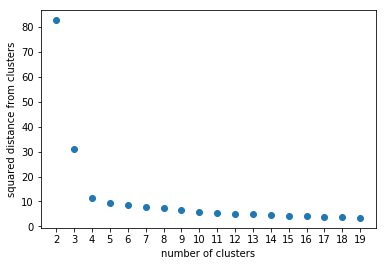

In [268]:
import matplotlib.pyplot as plt

plt.scatter(df_data['clusters'], df_data['sse'])
plt.xlabel('number of clusters')
plt.ylabel('squared distance from clusters')
plt.xticks(df_data['clusters'])
plt.show()

The error starts decreasing drastically at 4 clusters, so I'll use 4 clusters for this analysis

In [269]:
# set number of clusters
kclusters = 4

westcoast_grouped_clustering = west_coast_main.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(westcoast_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 3, 0, 3, 3, 2, 0, 1, 0, 1, 2, 3,
       0, 2, 0, 0, 0, 3, 0, 3, 2, 3, 2, 0, 0, 0, 3, 3, 0, 3, 3, 3, 0, 3,
       0, 3, 2, 3, 3, 0, 0, 0, 3, 0, 1, 3, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0,
       2, 2, 3, 2, 3, 0, 3, 2, 2, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0,
       0, 3, 3, 3, 2, 3, 3, 1, 0, 2, 3, 3, 3, 0, 0, 3, 3, 0, 1, 1, 2, 3,
       2, 3, 3, 3, 1, 2, 0, 0, 3, 0, 3, 3, 3, 0, 3, 2, 2, 3, 1, 0, 0, 3,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 0, 2, 0, 1, 3,
       0, 3, 0, 3, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 1, 2, 1, 3, 1, 0, 0, 3,
       3, 3, 2, 3, 3, 3, 3, 1, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 0, 3,
       2, 2, 0, 3, 3, 3, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 3, 3, 0, 0,
       2, 2, 3, 1, 1, 0, 0, 2, 3, 0, 0, 0, 0, 2, 3, 3, 0, 0, 3, 3, 3, 0,
       0, 3, 0, 2, 0, 3, 3, 1, 0, 0, 1, 0, 3, 3, 3, 0, 0, 0, 2, 3, 2, 3,
       0, 3, 3, 0, 0, 1, 2, 0, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 0, 3, 0, 3,
       3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 2, 3, 3,

In [278]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

west_coast_merged = all_cities

# merge west_coast_grouped with all_cities to add latitude/longitude for each neighborhood
west_coast_merged = west_coast_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

west_coast_merged.head() # check the last columns!

,Neighbourhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,37.776357,-122.434694,San Francisco,0.0,Eating Out,Entertainment,Bar,Sushi Restaurant,Cocktail Bar,Historic Site,Roller Rink,Boutique,BBQ Joint,Bakery
1,Anza Vista,37.780836,-122.443149,San Francisco,0.0,Eating Out,Café,Coffee Shop,Health & Beauty Service,Transit,Big Box Store,Burger Joint,Bus Station,Southern / Soul Food Restaurant,Convenience Store
3,Balboa Park,37.724949,-122.444805,San Francisco,2.0,Culture,Nature,Eating Out,Entertainment,Art Museum,Garden,Zoo Exhibit,Park,History Museum,Theme Park Ride / Attraction
5,Bayview,37.728889,-122.392500,San Francisco,0.0,Eating Out,Bakery,Entertainment,Southern / Soul Food Restaurant,Piercing Parlor,Farmers Market,Nature,Dance Studio,Mexican Restaurant,Pharmacy
6,Belden Place,37.791744,-122.403886,San Francisco,3.0,Eating Out,Coffee Shop,Entertainment,Gym,Culture,Food Truck,Sushi Restaurant,Restaurant,Latin American Restaurant,Gym / Fitness Center


In [298]:
west_coast_merged.groupby(['Cluster Labels', 'City']).count()

Neighbourhood  Latitude  Longitude  \
Cluster Labels City                                                
0.0            Los Angeles               42        42         42   
               San Diego                 28        28         28   
               San Francisco             42        42         42   
1.0            Los Angeles               10        10         10   
               San Diego                  9         9          9   
               San Francisco              2         2          2   
2.0            Los Angeles               17        17         17   
               San Diego                 13        13         13   
               San Francisco              8         8          8   
3.0            Los Angeles               55        55         55   
               San Diego                 55        55         55   
               San Francisco             29        29         29   

                              1st Most Common Venue  2nd Most Common Venue  \
Cluster Labels City                                                          
0.0            Los Angeles                       42                     42   
               San Diego                         28                     28   
               San Francisco                     42                     42   
1.0            Los Angeles                       10                     10   
               San Diego                          9                      9   
               San Francisco                      2                      2   
2.0            Los Angeles                       17                     17   
               San Diego                         13                     13   
               San Francisco                      8                      8   
3.0            Los Angeles                       55                     55   
               San Diego                         55                     55   
               San Francisco                     29                     29   

                              3rd Most Common Venue  4th Most Common Venue  \
Cluster Labels City                                                          
0.0            Los Angeles                       42                     42   
               San Diego                         28                     28   
               San Francisco                     42                     42   
1.0            Los Angeles                       10                     10   
               San Diego                          9                      9   
               San Francisco                      2                      2   
2.0            Los Angeles                       17                     17   
               San Diego                         13                     13   
               San Francisco                      8                      8   
3.0            Los Angeles                       55                     55   
               San Diego                         55                     55   
               San Francisco                     29                     29   

                              5th Most Common Venue  6th Most Common Venue  \
Cluster Labels City                                                          
0.0            Los Angeles                       42                     42   
               San Diego                         28                     28   
               San Francisco                     42                     42   
1.0            Los Angeles                       10                     10   
               San Diego                          9                      9   
               San Francisco                      2                      2   
2.0            Los Angeles                       17                     17   
               San Diego                         13                     13   
               San Francisco                      8                      8   
3.0            Los Angeles       

And now we can put the custers on the map. We can see all the cities by zooming out

In [279]:
# create map
map_clusters = folium.Map(location=[latitude_la, longitude_la], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red', 'green', 'blue', 'orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(west_coast_merged['Latitude'], west_coast_merged['Longitude'], west_coast_merged['Neighbourhood'], west_coast_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if np.isnan(cluster):
        cluster =0
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[int(cluster - 1)],
        fill=True,
        fill_color=rainbow[int(cluster - 1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We will now look into each specific cluster and see how they are similar to each other

In [280]:
west_coast_merged.loc[west_coast_merged['Cluster Labels']==0].head()

,Neighbourhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Square,37.776357,-122.434694,San Francisco,0.0,Eating Out,Entertainment,Bar,Sushi Restaurant,Cocktail Bar,Historic Site,Roller Rink,Boutique,BBQ Joint,Bakery
1,Anza Vista,37.780836,-122.443149,San Francisco,0.0,Eating Out,Café,Coffee Shop,Health & Beauty Service,Transit,Big Box Store,Burger Joint,Bus Station,Southern / Soul Food Restaurant,Convenience Store
5,Bayview,37.728889,-122.392500,San Francisco,0.0,Eating Out,Bakery,Entertainment,Southern / Soul Food Restaurant,Piercing Parlor,Farmers Market,Nature,Dance Studio,Mexican Restaurant,Pharmacy
8,Buena Vista,37.806532,-122.420648,San Francisco,0.0,Eating Out,Transit,Nature,Ice Cream Shop,Bike Rental / Bike Share,Tour Provider,Park,Entertainment,Chocolate Shop,Pizza Place
10,Castro,37.760856,-122.434957,San Francisco,0.0,Eating Out,Coffee Shop,Entertainment,Wine Bar,Culture,Gay Bar,History Museum,Historic Site,Bakery,Clothing Store


It looks like Cluster 0 has predominantly food venues with some entertainment and nature in the mix

In [281]:
west_coast_merged.loc[west_coast_merged['Cluster Labels']==1].head()

,Neighbourhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
73,Mount Davidson,37.738264,-122.453305,San Francisco,1.0,Nature,Park,Transit,Playground,Culture,Tree,Monument / Landmark,Bus Line,Falafel Restaurant,Farm
108,Twin Peaks,37.754640,-122.446480,San Francisco,1.0,Nature,Trail,Scenic Lookout,Transit,Bus Stop,Bus Station,Garden,Tailor Shop,Reservoir,Indie Movie Theater
5,Baldwin Hills,34.007568,-118.350596,Los Angeles,1.0,Nature,Trail,Park,Transit,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
17,Beverlywood,34.046633,-118.395038,Los Angeles,1.0,Nature,Park,Paper / Office Supplies Store,Transit,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
68,Griffith Park,34.134427,-118.305092,Los Angeles,1.0,Nature,Nature Preserve,Eating Out,Park,Tea Room,Trail,Transit,Flea Market,Factory,Falafel Restaurant


Cluster 1 on the other hand has neighborhoods with lots of natural sights. They are also closer to transit locations

In [282]:
west_coast_merged.loc[west_coast_merged['Cluster Labels']==2].head()

,Neighbourhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Balboa Park,37.724949,-122.444805,San Francisco,2.0,Culture,Nature,Eating Out,Entertainment,Art Museum,Garden,Zoo Exhibit,Park,History Museum,Theme Park Ride / Attraction
18,Corona Heights,37.764886,-122.439368,San Francisco,2.0,Eating Out,Nature,Park,Culture,Cosmetics Shop,Scenic Lookout,Entertainment,Gay Bar,Szechuan Restaurant,Hill
39,Hunters Point,37.726771,-122.371572,San Francisco,2.0,Outdoor Sculpture,Spa,Nature,Eating Out,Harbor / Marina,Grocery Store,Factory,Falafel Restaurant,Farm,Farmers Market
40,India Basin,37.736042,-122.370526,San Francisco,2.0,Home Service,Transit,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service
49,Laguna Honda,37.747977,-122.459117,San Francisco,2.0,Nature,Eating Out,Trail,Light Rail Station,Transit,Lake,Event Space,Park,Bus Stop,French Restaurant


Cluster 2 neighbourhoods are a mix of culture and natural sights

In [283]:
west_coast_merged.loc[west_coast_merged['Cluster Labels']==3].head()

,Neighbourhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Belden Place,37.791744,-122.403886,San Francisco,3.0,Eating Out,Coffee Shop,Entertainment,Gym,Culture,Food Truck,Sushi Restaurant,Restaurant,Latin American Restaurant,Gym / Fitness Center
7,Bernal Heights,37.741001,-122.414214,San Francisco,3.0,Eating Out,Entertainment,Coffee Shop,Bakery,Gourmet Shop,Italian Restaurant,Nature,Park,Grocery Store,Gym
14,Chinatown,37.794301,-122.406376,San Francisco,3.0,Eating Out,Chinese Restaurant,Bakery,Coffee Shop,Vietnamese Restaurant,Culture,Bar,Entertainment,Dim Sum Restaurant,Szechuan Restaurant
19,Cow Hollow,37.797262,-122.436248,San Francisco,3.0,Eating Out,Nature,French Restaurant,Italian Restaurant,Entertainment,Wine Bar,Cycle Studio,Thai Restaurant,Salad Place,Trail
23,Dogpatch,37.760698,-122.389202,San Francisco,3.0,Eating Out,Entertainment,Café,Cocktail Bar,Wine Bar,Bakery,Brewery,Gift Shop,Bar,Southern / Soul Food Restaurant


Cluster 3 neighborhoods look like vibrant places with unique food, culture and entertainment scene

We'll now take a bit of a deeper dive into our clusters by creating some radar plots of our clusters. We'll first create some tables with means of each cluster for our clsutering variables

In [285]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns = westcoast_grouped_clustering.columns.values[:])

In [286]:
cluster_centers

,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit
0,0.014808,0.483022,0.034959,0.072291,0.064511,0.009652
1,0.000000,0.011905,0.007937,0.808503,0.006803,0.014739
2,0.027735,0.124663,0.105324,0.160168,0.161666,0.020983
3,0.012466,0.710314,0.018245,0.023735,0.043737,0.003086


Let's create those radar plots now. These radar plots are designed in such a way that the orange shape represents the average while the blue shape represents the average of a specific cluster thereby showing how this particular cluster is different from the overall population

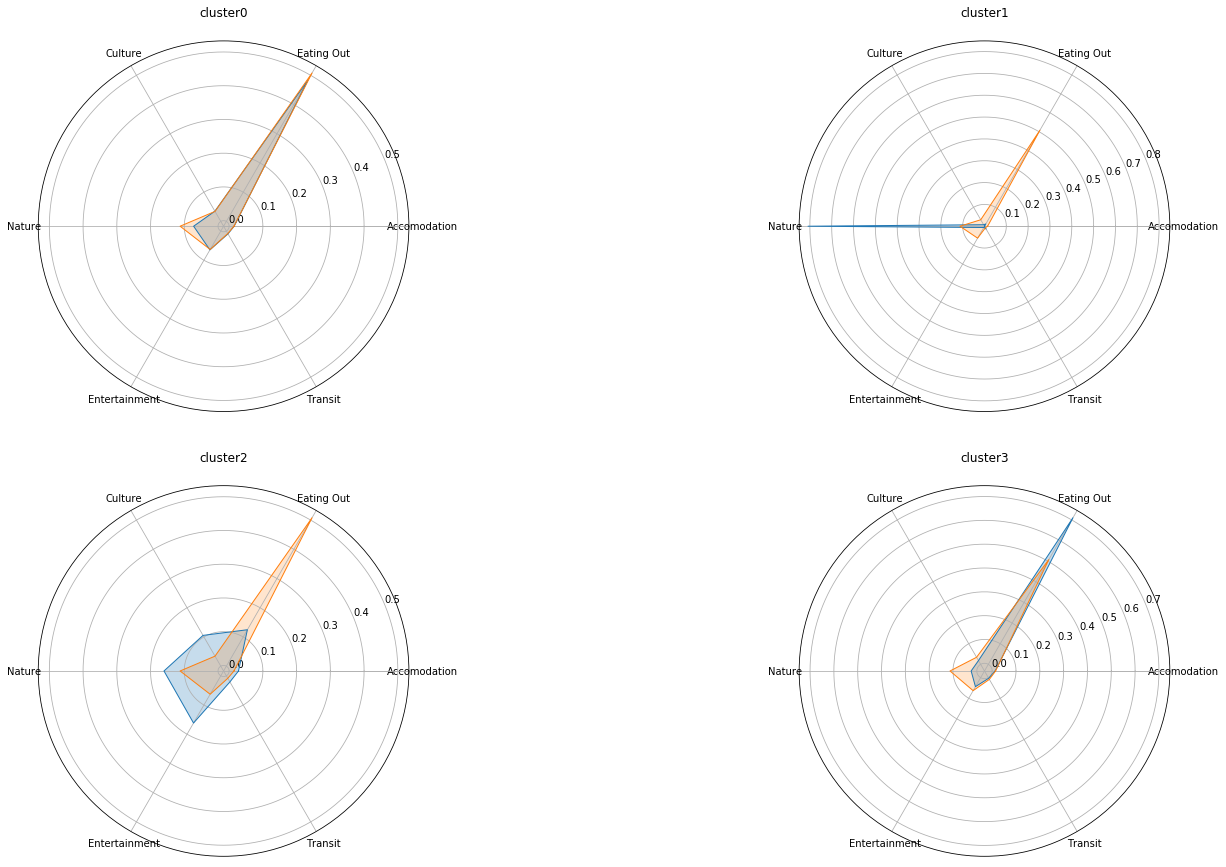

In [289]:
import seaborn as sns
labels  = westcoast_grouped_clustering.columns.values[:]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(25)

for i in cluster_centers.index.values:
    stats = cluster_centers.iloc[i,:].values
    stats = np.concatenate((stats, [stats[0]]))
    avg = np.mean(westcoast_grouped_clustering.iloc[:, :])
    avg = np.concatenate((avg, [avg[0]]))
    ax = fig.add_subplot(2,2,i+1, polar = True)
    ax.plot(angles, stats, '-', linewidth=1)
    ax.plot(angles, avg, '-', linewidth = 1)
    ax.fill(angles, stats, alpha=0.25)
    ax.fill(angles, avg, alpha=0.2)
    ax.set_thetagrids(angles*180/np.pi, labels)
    ax.set_title('cluster' + str(i))
    ax.grid(True)

Similar to previously discussed analysis, they show that clusters 0 and 3 are indeed pretty similar to each other, with cluster 3 having slightly less nature and slightly more food venues than cluster 0. Cluster 1 is confirmed to have lots of nature sights, while cluster 2 neighbourhoods look like they have busier cultural and entertainment scene.

### Use Case 1: Selecting Similar Neighborhood

My Use Case 1 will be fairly simple and will just use the clustering model I developed earlier. 

*Imagine a person, let's name her Pam, who lives in one of the cities on West Coast. Let's say, Pam lives in Los Angeles in Hollywood Hills neighborhood. Pam loves just about everything about the place she lives. In a month, she is going for a vacation in San Diego. She definitely wants to explore the city, but she also wants for the neighborhood she stays at to be as similar to Hollywood Hills as possible. She wants to know which neighborhoods she should consider staying at. She also wants to know about the popular spots in that area*

So, for this use case I will just use the results of the clustering. First, I will find out which cluster Hollywood Hills belongs to.

In [299]:
west_coast_merged.loc[west_coast_merged['Neighbourhood']== 'Hollywood Hills']

,Neighbourhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Hollywood Hills,34.131179,-118.335547,Los Angeles,1.0,Nature,Trail,Transit,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant


It's Cluster 1! Now we can search the table for Cluster 1 neighbourhoods in San Diego

In [300]:
san_diego = west_coast_merged.loc[west_coast_merged['City']== 'San Diego']

In [301]:
matching_neighbourhoods = san_diego.loc[san_diego['Cluster Labels']==1.0]

In [302]:
matching_neighbourhoods

,Neighbourhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Del Mar Mesa,32.941434,-117.182535,San Diego,1.0,Nature,Trail,Transit,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
16,Black Mountain Ranch,32.984117,-117.131932,San Diego,1.0,Nature,Park,Transit,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
21,Rancho Encantada,32.924815,-117.022173,San Diego,1.0,Nature,Park,Transit,Flower Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
23,Sabre Springs,32.953379,-117.094477,San Diego,1.0,Nature,Trail,Park,Mobile Phone Shop,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
33,Navajo,32.800908,-117.059085,San Diego,1.0,Nature,Playground,Transit,Flea Market,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
55,Sunset Cliffs,32.730500,-117.253200,San Diego,1.0,Nature,Scenic Lookout,Beach,Transit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
65,Marina,32.785738,-117.041678,San Diego,1.0,Nature,Trail,Reservoir,Flea Market,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
82,Islenair,32.733175,-117.099658,San Diego,1.0,Trail,Nature,Indie Movie Theater,Flower Shop,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
85,Oak Park,32.737179,-117.070855,San Diego,1.0,Nature,Trail,Baseball Field,Playground,Flea Market,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market


In [325]:
map_clusters = folium.Map(location=[latitude_sd, longitude_sd], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red', 'green', 'blue', 'orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(matching_neighbourhoods['Latitude'], matching_neighbourhoods['Longitude'], matching_neighbourhoods['Neighbourhood'], matching_neighbourhoods['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if np.isnan(cluster):
        cluster =0
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[int(cluster - 1)],
        fill=True,
        fill_color=rainbow[int(cluster - 1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see, there are several neighborhoods. Let's imagine that now Claire wants to know which one of them will be the closes to Hollywood Hills. We'll use the same logic used in clustering to find this neighbourhood

In [303]:
san_diego_neigh = pd.DataFrame(matching_neighbourhoods['Neighbourhood'])

In [304]:
san_diego_neigh = san_diego_neigh.merge(west_coast_main, left_on = 'Neighbourhood', right_on = 'Neighborhood')

In [305]:
san_diego_neigh = san_diego_neigh.drop(['Neighborhood'], axis =1)

In [306]:
san_diego_neigh

,Neighbourhood,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit
0,Del Mar Mesa,0.0,0.0,0.0,1.000000,0.0,0.0
1,Black Mountain Ranch,0.0,0.0,0.0,1.000000,0.0,0.0
2,Rancho Encantada,0.0,0.0,0.0,1.000000,0.0,0.0
3,Sabre Springs,0.0,0.0,0.0,0.666667,0.0,0.0
4,Navajo,0.0,0.0,0.0,1.000000,0.0,0.0
5,Sunset Cliffs,0.0,0.0,0.0,1.000000,0.0,0.0
6,Marina,0.0,0.0,0.0,0.800000,0.0,0.0
7,Islenair,0.0,0.0,0.0,0.500000,0.0,0.0
8,Oak Park,0.0,0.0,0.0,0.666667,0.0,0.0


In [307]:
hollywood_hills = west_coast_main.loc[west_coast_main['Neighborhood']=='Hollywood Hills']

In [308]:
hollywood_hills

,Neighborhood,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit
106,Hollywood Hills,0.0,0.0,0.0,1.0,0.0,0.0


Now I will find a neighborhood(s) in San Diego with the closest distances to Hollywood Hills

In [309]:
distances= []
for row in np.array(san_diego_neigh):
    error = np.sum((row[1:]-np.array(hollywood_hills.iloc[:,1:]))**2)
    distances.append(error)
match = min(distances)
index_list =[]
n=0
for i in distances:
    if i==match:
        index_list.append(n)
    n+=1
neighbourhood_list = san_diego_neigh.iloc[index_list, :]

In [310]:
neighbourhood_list

,Neighbourhood,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit
0,Del Mar Mesa,0.0,0.0,0.0,1.0,0.0,0.0
1,Black Mountain Ranch,0.0,0.0,0.0,1.0,0.0,0.0
2,Rancho Encantada,0.0,0.0,0.0,1.0,0.0,0.0
4,Navajo,0.0,0.0,0.0,1.0,0.0,0.0
5,Sunset Cliffs,0.0,0.0,0.0,1.0,0.0,0.0


And so we have a list of neighborhoods that are closest to Hollywood Hills!

### Use Case 2: Recommender Tool

My Use Case #2 wil involve creating a Recommender System that will create recommend neighbourhoods to stay at in the new city based on the tourist's rankings of neighbourhoods in their hometown or other places they've already traveled to. So, I will use content based recommendations for this task.

*Imagine we have a prospective tourist Jim who lives in Los Angeles and has to go to San Francisco for a business meeting. Jim has rated several neighbourhoods in Los Angeles on a 1-5 scale where 5 is the highest ranking and 1 is the lowest. Jim has also went to San Diego for vacation last year and ranked some neighbourhoods there as well. Jim wants to know the names of neighbourhoods in San Francisco that would be the best for him to visit or stay at.*

Here is a list of Jim's rankings. It is completely arbitrary and made up by me

In [311]:
neigh_ratings = [['Venice', 5], ['Beverlywood', 4], ['Hollywood Hills',2], ['Canoga Park',3], ['Del Rey', 3], 
                 ['Downtown', 2], ['Fashion District', 1], ['Koreatown', 3], ['Pacific Palisades', 5], 
                 ['Skid Row',1], ['Tujunga', 4], ['Del Mar Messa', 4], ['La Jolla', 5], ['Pacific Beach', 3],
                 ['Encanto', 1], ['Palm City', 3]]

In [312]:
ratings_df = pd.DataFrame(neigh_ratings, columns = ['Neighbourhood', 'Rating'])

We will now obtain a set with all the neighbourhoods in San Francisco along with their ratings

In [313]:
san_fran_neighbourhoods = west_coast_merged.loc[west_coast_merged['City']=='San Francisco']

In [314]:
san_fran_neighbourhoods = pd.DataFrame(san_fran_neighbourhoods['Neighbourhood'])

In [315]:
san_fran_neighbourhoods = san_fran_neighbourhoods.merge(west_coast_main, left_on = 'Neighbourhood', right_on = 'Neighborhood')

In [316]:
san_fran_neighbourhoods = san_fran_neighbourhoods.drop(['Neighborhood'], axis=1)

In [317]:
san_fran_neighbourhoods.head()

,Neighbourhood,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit
0,Alamo Square,0.000000,0.533333,0.033333,0.033333,0.166667,0.000000
1,Anza Vista,0.000000,0.550000,0.000000,0.000000,0.000000,0.050000
2,Balboa Park,0.000000,0.186047,0.279070,0.186047,0.139535,0.023256
3,Bayview,0.000000,0.545455,0.000000,0.090909,0.181818,0.000000
4,Belden Place,0.033333,0.666667,0.066667,0.000000,0.133333,0.000000


I will now find the rated neighbourhoods in our general set to see the features of these neighbourhoods

In [318]:
ratings_df = ratings_df.merge(west_coast_main, left_on = 'Neighbourhood', right_on = 'Neighborhood').drop(['Neighborhood'], axis=1)

In [326]:
ratings_df

,Neighbourhood,Rating,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit
0,Venice,5,0.000000,0.366667,0.033333,0.000000,0.100000,0.000000
1,Beverlywood,4,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
2,Hollywood Hills,2,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
3,Canoga Park,3,0.000000,0.588235,0.058824,0.000000,0.000000,0.000000
4,Del Rey,3,0.000000,0.750000,0.000000,0.000000,0.125000,0.000000
5,Downtown,2,0.000000,0.375000,0.083333,0.000000,0.166667,0.083333
6,Fashion District,1,0.000000,0.500000,0.166667,0.000000,0.000000,0.000000
7,Koreatown,3,0.074074,0.666667,0.000000,0.074074,0.111111,0.000000
8,Pacific Palisades,5,0.000000,0.633333,0.000000,0.033333,0.033333,0.000000
9,Skid Row,1,0.000000,0.600000,0.066667,0.000000,0.133333,0.000000


Since in this case we are only interested in parameters for a single user (Jim), we can just use basic linear regression. For more users, we would need to use a more complicated recommender system algorithm

In [320]:
from sklearn.linear_model import LinearRegression
X=ratings_df.iloc[:, 2:]
y=ratings_df.iloc[:, 1]
lin_reg = LinearRegression().fit(X, y)

Now, I'll predict Jim's ratings of San Francisco neighbourhoods

In [321]:
san_fran_predicted = lin_reg.predict(san_fran_neighbourhoods.iloc[:, 1:])

I will join the predicted ratings on existing dataframe

In [322]:
san_fran_neighbourhoods['Rating'] = pd.DataFrame(san_fran_predicted)

Now, I will get the names of top 5 neighbourhoods recommended to Jim

In [323]:
san_fran_neighbourhoods = san_fran_neighbourhoods.sort_values(['Rating'], ascending=False)

In [324]:
san_fran_neighbourhoods.head()

,Neighbourhood,Accomodation,Eating Out,Culture,Nature,Entertainment,Transit,Rating
30,India Basin,0.0,0.000000,0.0,0.000000,0.000000,0.0,6.351214
27,Haight-Ashbury,0.0,0.366667,0.0,0.033333,0.033333,0.0,4.568207
75,Treasure Island,0.0,0.307692,0.0,0.153846,0.076923,0.0,4.267396
11,Cole Valley,0.0,0.433333,0.0,0.033333,0.166667,0.0,4.168311
29,Hunters Point,0.0,0.250000,0.0,0.250000,0.000000,0.0,4.163750


And here we have neighbourhoods ranked top 5 for Jim